---
title: "VRPCD with information exchange using Google OR tools data"
author: "FA"
date: 2021-01-07
tags: ["VRPCD", "realtime", "information exchange", "G-Tools data"]
categories: "research"
---

In [ ]:
#*****************************************
# Necessary Package
#*****************************************
using Random
using JuMP
using LinearAlgebra
using GLPK
using DataFrames
using CSV

In [ ]:
#*****************************************
# Network Property
#*****************************************
# O1: dummy cross-dock
O_dum_pick = [1]
O_dum_del = [20]

# P: set of pickup nodes
P = [2,3]

# O: cross-dock (assume single cross dock in the network)
O_pick = [10]
O_del = [11]

# D: set of delivery nodes
D = [12,13]

# pickup nodes
N_pickup = vcat(O_dum_pick, P, O_pick)

# delivery nodes
N_delivery = vcat(O_del, D, O_dum_del)

# all nodes
N = vcat(O_dum_pick, P, O_pick, O_del, D, O_dum_del)

# M: set of available vehicles
M = [1,2]

# may be we need to position each entity in a graph to find distance/ time automatically
print(P,D,O_pick, O_del, N_pickup, N_delivery, N, M)


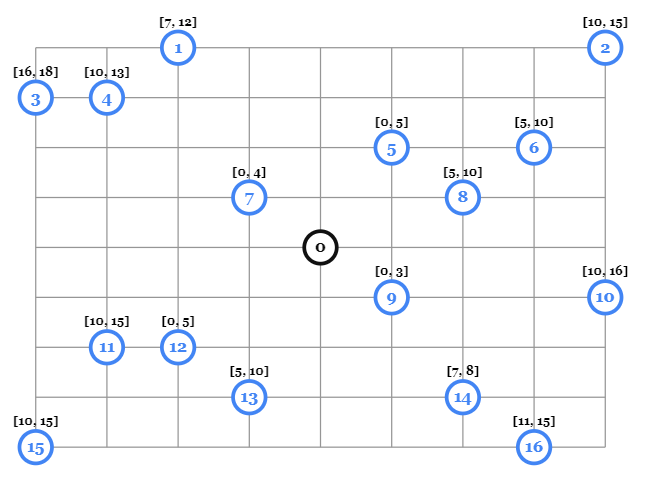

In [ ]:
# time windows for each node
tw_i = [
        (0, 100),  # 1 dummy depot
        (0,100),  # 2
        (0, 100),  # 3
        (0, 1004),  # 4
        (0, 1003),  # 5
        (0, 100),  # 6
        (0, 100),  # 7
        (0, 100),  # 8
        (0, 100),  # 9
        (0,240), # 10 Depot: PICKUP
        (0,240), # 11 Depot: DELIVERY
        (0, 105),  # 12
        (0, 160),  # 13
        (0, 150),  # 14
        (0,105),  # 15
        (0, 100),  # 16
        (0, 120),  # 17
        (0, 150),  # 18
        (0, 150),  # 19
        (0, 50)  # 20 dummy depot
    ]

for i=1:length(tw_i)
    print("node: ", i, "\t", "TW: ", tw_i[i], "\n")
end

In [ ]:
# c_ij = the travel time (minutes)/cost between node i and node j; (assuming the cost is the same as the time req.)
#B = 999
time_mat = CSV.read("C:\\Users\\ahmedf\\Documents\\AHMED\\AHMED\\RESEARCH\\Research_Freight-Cross-Dock\\optim_freight\\cross-dock\\julia_jump\\time_matrix.csv", DataFrame)

In [ ]:
t_ij = time_mat[:, 2:21]

In [ ]:
#****************************************
# parameters
#*****************************************

# ---------- Nodes
# p = number of pickup nodes
p = length(P)

# d = number of delivery nodes
d = length(D)

# o = number of cross dock
o_pick = length(O_pick)
o_del = length(O_del)


# p_cd: number of nodes in pickup process (dummy CD + P + CD)
p_cd = length(N_pickup)

# d_cd: number of nodes in delivery process (CD + P + dummy CD)
d_cd = length(N_delivery)

# n: total nodes in the network
n = length(N)

# p_i: quantity of products to be collected at pickup node i; [include product type in future]
 #    [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
p_i = [0, 30, 50, 30, 30, 30, 30, 30, 30,  0,  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# d_i: quantity of products to be delivered at delivery node i; [include product type in future]
 #    [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
d_i = [0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0, 30, 50, 30, 50, 30, 30, 30, 30, 0]



# a_i: starting time window of node i
a_i = []

# b_i: ending time window of node i
b_i = []
for i=1:length(tw_i)
    push!(a_i, tw_i[i][1])
    push!(b_i, tw_i[i][2])
end


# --------- vehicles

# number of availble vehicles
m = length(M)

# capacity of vehicle (homogenous); in-future define as cap/veh
Q = 100

# Random.seed!(314)
# travel time matrix for all nodes


# Cross-dock activity time
T_o = 0

# time horizon (16 hr a day)
T_max = 16*60

print("Pickup Product @nodes: ", p_i, "\n")
print("Delivery Product @nodes: ", d_i, "\n")
print("Earliest arrival @nodes: ", a_i, "\n")
print("Latest arrival @nodes: ", b_i, "\n")

In [ ]:
# ****************************************
# Create a JuMP model
# ****************************************
cd_modl = Model(GLPK.Optimizer)

# ****************************************
# Decision variables
#*****************************************

# x_ijk = 1 if vehicle k travels from node i to node j; 0 otherwise;
@variable(cd_modl, x_ijk[i=N, j=N, k=M], Bin)

# y_i = total quantity of collected/delivered products after leaving node i
@variable(cd_modl, y_i[i = N] >= 0)

# v_ik = 1 if vehicle k visits node i; 0 otherwise
# @variable(cd_modl, v_ik[i = N, k = M], Bin)

# s_ik = arrival time at node i by vehicle k
@variable(cd_modl, s_ik[i = N, k = M] >= 0)

# l_ik = tardiness (tardiness/lateness = upper TW (b_i) - arrival time (s_ik)) at node i by vehicle k ==> this would be a non-linear constraint
# l_i = tardiness at node i
@variable(cd_modl, l_ik[i= N, k = M] >= 0)

# t_pickup = latest arrival time a cross dock
@variable(cd_modl, t_pick>=0)

# AT_k = arrival time of vehicle k at the cross-dock
@variable(cd_modl, AT_k[k =M]>=0)

In [ ]:
#*****************************************
# Constraints
#*****************************************

# Pick-up Process
#----------------

# [Pick-up Process] 01: only one vehicle can arrive at a pickup node
@constraint(cd_modl, p_node_entry[j= P],
                    sum(x_ijk[i,j,k] for i=vcat(O_dum_pick, P) for k=1:m if i != j) == 1)

#[Pick-up Process] 02: Only one vehicle depart from the pickup node
@constraint(cd_modl, p_node_exit[i= P],
                    sum(x_ijk[i,j,k] for j=vcat(P,O_pick) for k=1:m if i != j) == 1)

# [Pick-up Process] 03: Consecutive movement of vehicles
@constraint(cd_modl, cons_move_pick[l = P, k=1:m],
    sum(x_ijk[i,l,k] for i=vcat(O_dum_pick, P) if i != l) 
    -sum(x_ijk[l,j,k] for j=vcat(P,O_pick) if j != l) 
    == 0)

# [Pick-up Process] 04: vehicle leave at dummy cross dock
@constraint(cd_modl, p_dum_leave[i= O_dum_pick, k=1:m],
    sum(x_ijk[i,j,k] for j = P) <= 1)


# [Pick-up Process] 05: vehicle that leave at dummy cross dock visit cross dock immdiately after last pickup
@constraint(cd_modl, p_cd_entry[j = O_pick, k=M],
    sum(x_ijk[i,j,k] for i= P) <= 1)


# [Pick-up Process] 06:  track vehicles k visits to nodes i
# @constraint(cd_modl, veh_visit_pick[i = vcat(O_dum_pick, P, O_pick), k=M],
#     sum(x_ijk[j,i,k] for j= vcat(O_dum_pick, P) if i != j) <= v_ik[i,k])


# [Pick-up Process] 06: 
@constraint(cd_modl, p_pick_qnt[i = P, j = P,  k=M; i!=j],
    y_i[j] 
    - y_i[i] 
    - p_i[j] 
    + Q 
    - (Q*(x_ijk[i,j,k] + x_ijk[j,i,k])) 
    + ((p_i[j]+p_i[i])*x_ijk[j,i,k])
    >= 0)

# [Pick-up Process] 07: 
@constraint(cd_modl, p_pick_qnt2[i = O_dum_pick, j = P, k=M],
    y_i[j]
    - x_ijk[i,j,k]*p_i[j]
    - (1-x_ijk[i,j,k])*Q
    <= 0)

# [Pick-up Process] 08a: does not exceed the capacity of the trucks
@constraint(cd_modl, pick_cap1[i = P],
    y_i[i] >= p_i[i] )

# [Pick-up Process] 08b: does not exceed the capacity of the trucks 
@constraint(cd_modl, pick_cap2[i = P],
    y_i[i] <= Q)

# # [Pick-up Process] 09: track the arrival time of vehicle k at node i
@constraint(cd_modl, serv_time_pick[i = vcat(O_dum_pick, P, O_pick), j = vcat(O_dum_pick, P, O_pick),k= M; i !=j],
        s_ik[i,k] + t_ij[i][j] - B*(1 - x_ijk[i,j,k]) <= s_ik[j,k]
)


# [Pick-up Process] 10: calculate the tardiness of vehicle arrival at node i
@constraint(cd_modl, tard_pick[j=vcat(O_dum_pick, P, O_pick), k=M],
    s_ik[j,k] 
    - b_i[j] 
    + B*(sum(x_ijk[i,j,k] for i = vcat(O_dum_pick, P, O_pick) if i !=j) - 1) 
    <= l_ik[j,k]
)



In [ ]:
@show p_pick_qnt2

In [ ]:
#*****************************************
# Constraints
#*****************************************

# Delivery Proc

#----------------

# [Delivery Process] 01: only one vehicle can arrive at a pickup node
@constraint(cd_modl, d_node_entry[j= D],
                    sum(x_ijk[i,j,k] for i=vcat(O_del, D) for k=1:m if i != j) == 1)

# [Delivery Process] 02: Only one vehicle depart from the pickup node
@constraint(cd_modl, d_node_exit[i= D],
                    sum(x_ijk[i,j,k] for j=vcat(D,O_dum_del) for k=1:m if i != j) == 1)

# [Delivery Process] 03: Consecutive movement of vehicles
@constraint(cd_modl, cons_move_del[l = D, k=1:m],
    sum(x_ijk[i,l,k] for i=vcat(O_del, D) if i != l) 
    -sum(x_ijk[l,j,k] for j=vcat(D,O_dum_del) if j != l) 
    == 0)

# [Delivery Process] 04: vehicle enter at dummy cross dock after last delivery
@constraint(cd_modl, d_dum_enter[k=1:m],
    sum(x_ijk[i,j,k] for i= D for j = O_dum_del) <= 1)

# [Delivery Process] 05: vehicle leave cross dock
@constraint(cd_modl, d_cd_leave[k=1:m],
    sum(x_ijk[i,j,k] for i= O_del for j = D) <= 1)

# [Delivery Process] 06: 
@constraint(cd_modl, d_del_qnt[k=1:m, i = D, j = D; i!=j],
    y_i[j] 
    - y_i[i] 
    - d_i[j] 
    + Q 
    - (Q*(x_ijk[i,j,k] + x_ijk[j,i,k])) 
    + ((d_i[j]+d_i[i])*x_ijk[j,i,k])
    >= 0)

# [Delivery Process] 07: 
@constraint(cd_modl, d_del_qnt2[i = O_del, j = D, k=1:m],
    y_i[j]
    - x_ijk[i,j,k]*d_i[j]
    - (1-x_ijk[i,j,k])*Q
    <= 0)

# [Delivery Process] 08a: 
@constraint(cd_modl, del_cap1[i = D],
    y_i[i] >= d_i[i] )

# [Delivery Process] 08b: 
@constraint(cd_modl, del_cap2[i = D],
    y_i[i] <= Q)

# [Delivery Process] 09: track the start of service time of vehicle k at node i
@constraint(cd_modl, serv_time_del[i = vcat(O_del, D, O_dum_del), j = vcat(O_del, D, O_dum_del),k= M; i !=j],
        s_ik[i,k] + t_ij[i][j] - B*(1 - x_ijk[i,j,k]) <= s_ik[j,k]
)

@constraint(cd_modl, init_serv_time_del[i = O_del,k= M],
        s_ik[i,k] == t_pick
)


# [Delivery Process] 10: calculate the tardiness of vehicle arrival at node i
@constraint(cd_modl, tard_del[j=vcat(O_del, D, O_dum_del), k=M],
    s_ik[j,k] 
    - b_i[j] 
    + B*(sum(x_ijk[i,j,k] for i = vcat(O_del, D, O_dum_del) if i !=j) - 1) 
    <= l_ik[j,k]
)



# [delivery Process] 10: calculate the tardiness of vehicle arrival at node i
# @constraint(cd_modl, del_tard[i = vcat(D, O_dum_del), k=M],
#     l_ik[i,k] >= s_ik[i,k] - b_i[i]
# )


# # [Delivery Process] 10a: the start of servicing node i by vehicle k must be greater than the start of TW
# @constraint(cd_modl, del_TW_begin[i = vcat(O_del, D), k = M],
#     s_ik[i,k] >= a_i[i])

# # [Pick-up Process] 10b: the end of servicing node i by vehicle k must be greater than the end of TW
# @constraint(cd_modl, del_TW_end[i = vcat(O_del, D), k = M],
#     s_ik[i,k] <= b_i[i])

In [ ]:
#*****************************************
# Constraints
#*****************************************

# @cross dock:: Connection Between Pickup and Delivery Process (using time)
#------------------------------------------------------------

# [cross-dock] 01: track time for product collection in the pickup process
@constraint(cd_modl, cd_prod_col[k = M],
    AT_k[k]
    -sum(t_ij[i][j] * x_ijk[i,j,k] for i=vcat(O_dum_pick, P) for j=vcat(P, O_pick) if i != j) >= 0)

# [cross-dock] 02: all trucks arrive at the same time at cross-dock
@constraint(cd_modl, cd_truck_arr[k = M, k_prime = M; k != k_prime],
    AT_k[k] - AT_k[k_prime] == 0)

# [cross-dock] 03: total time at the pickup process
@constraint(cd_modl, time_pick[k = M],
    t_pick - AT_k[k] >= 0)

# [cross-dock] 04: total transportation time and processing time does not exceed the planning horizon T_max
@constraint(cd_modl, time_hor[k = 1: m],
    t_pick + T_o + sum(t_ij[i][j] * x_ijk[i,j,k] for i = vcat(O_del, D) for j = vcat(D, O_dum_del)) - T_max <= 0)


In [ ]:
#****************************************
# Objective
#*****************************************
# minimization problem (convex optimization)

# min travel time for pickup process
# min travel time for delivery process
# min tardiness at customer location

@objective(cd_modl, Min, 
    sum(t_ij[i][j]*x_ijk[i,j,k] for i=vcat(O_dum_pick, P) for j=vcat(P, O_pick) for k=M) 
    + sum(t_ij[i][j]*x_ijk[i,j,k] for i=vcat(O_del, D) for j=vcat(D, O_dum_del) for k=M)
    + sum(B * l_ik[i,k] for i = N for k=M)

)

In [ ]:
optimize!(cd_modl)

In [ ]:
@show objective_value(cd_modl)

In [ ]:
@show value.(x_ijk);

In [ ]:
@show value.(y_i)

In [ ]:
@show value.(v_ik)

In [ ]:
@show value.(AT_k);

In [ ]:
@show value.(t_pick);

In [ ]:
@show value.(s_ik)

In [ ]:
@show value.(l_ik)

In [ ]:
# vehicle routing information
print( "t \t from \t to \t veh \t tt \t prod_amt_j \n")

temp = 0
for k=1:m
    for i= 1:n
        for j=1:n
            if value.(x_ijk[i,j,k]) > 0
                temp = temp + t_ij[i,j]
                print("0 \t", i, "\t", j, "\t",k, "\t", temp, "\t", value.(y_i[j]), "\n")
            end
            temp = 0
        end
    end
end

In [ ]:
# vehicle arrival time
print( "veh \t node \t arr_time \n")

temp = 0
for k=1:m
    for i= 1:n
        if value.(s_ik[i,k]) > 0
            print(k, "\t", i, "\t", value.(s_ik[i,k]), "\n")
        end
    end
end

In [ ]:
# vehicle tardiness at nodes
print( "veh \t node \t tardiness \n")

temp = 0
for k=1:m
    for i= 1:n
        if value.(l_ik[i,k]) > 0
            print(k, "\t", i, "\t", value.(l_ik[i,k]), "\n")
        end
    end
end

In [ ]:
using DataFrames
pick_amt = DataFrame(node =[], amount =[])

for k in keys(y_i)
    print(k[1])
    val = getvalue.(y_i[k[1]])
    print(val)
    push!(pick_amt, vcat(k[1], val))
end

pick_amt


In [ ]:
mvmt_pick = DataFrame(from=[], to=[], veh=[], status=[])
mvmt_del = DataFrame(from=[], to=[], veh=[], status=[])

print("key \t\t from \t to \t veh \t status \n")
for k in keys(x_ijk)
    key = Tuple(k[:])
    from_node = key[1]
    to_node = key[2]
    veh = key[3]
    val = getvalue.(x_ijk[key...])
    if val > 0
        print( "x",[key...], "\t", key[1], "\t", key[2] , "\t", key[3] , "\t", val, "\n")
    end
    
    # record the routing of pickup process
#     if val > 0 && to_node <= 4
#         print(key , "\t", key[1], "\t", key[2] , "\t", key[3] , "\t", val, "\n")
#         push!(mvmt_pick, vcat([key...], val))
#     end
    
#     # record the routing of delivery process
#     if val > 0 && end_node > 4
#         push!(mvmt_del, vcat([key], val))
#     end
end

mvmt_pick

In [ ]:
mvmt_pick

In [ ]:
mvmt_del

In [ ]:
# inialize empty array to capture travel time, tt
tt_pick = []
prod_pick = []
for i=1:nrow(mvmt_pick)
    x = Int(mvmt_pick[i,1])
    y = Int(mvmt_pick[i,2])
    prod_amt = pick_amt[y, 2]
    print(x, "\t", y, "\t", prod_amt, "\n")
    append!(tt_pick,t_ij[x,y]) ## append data to the tt array
    append!(prod_pick,prod_amt)
end

tt_pick
prod_pick
insert!(mvmt_pick, 5, tt_pick, :tt)
insert!(mvmt_pick, 6, prod_pick, :prod_amt)

In [ ]:
# inialize empty array to capture travel time, tt
tt_del = []
prod_del = []
for i=1:nrow(mvmt_del)
    x = Int(mvmt_del[i,1])
    y = Int(mvmt_del[i,2])
    prod_amt = pick_amt[y, 2]
    append!(tt_del,t_ij[x,y]) ## append data to the tt array
    append!(prod_del,prod_amt)
end

tt_del

#insert!(mvmt_del, 5, tt_del, :tt)
insert!(mvmt_del, 6, prod_del, :prod_del)

In [ ]:
# group by vehicle number and sum the travel time to get the estimated arrival at cross-dock
cd_arr_time = combine(groupby(mvmt_pick,  [:veh]) , :tt => sum)

In [ ]:
# group by vehicle number and sum the travel time to get the estimated arrival at cross-dock
cd_product = combine(groupby(mvmt_pick,  [:veh]) , :prod_amt => sum)

In [ ]:
join(cd_arr_time, cd_product, on = :veh)

In [ ]:
del_time = combine(groupby(mvmt_del,  [:veh]) , :tt => sum)

est_del = []
for i= 1:nrow(del_time)
    temp = del_time[i, 2] + value.(t_pick)[1]  # add the latest time for pickup process
    append!(est_del, temp)
end

insert!(del_time, 3, est_del, :est_del)

In [ ]:
for t in [0:15:120;]
    print("\n\ncurrent time: ", t)
    # check status of each vehicle
    
    # where is the position of each vehicle?
    # is the current time less than t_pick? if yes "pickup process"; "delivery process" other wise
    tt = []
    tt_del = []
    if t <= value.(t_pick)[1]
        print("\nvehicles in PICKUP process")
        for i=1:nrow(cd_arr_time)
            curr_arr_time = cd_arr_time[i,2]
            update_time = curr_arr_time - t
            append!(tt, update_time)
        end
        
        # update time for delivery process
        for i=1:nrow(del_time)
            curr_del_time = del_time[i,3]
            update_time = curr_del_time - t
            append!(tt_del, update_time)
        end
        
        # print table
        cd_arr_time.est = tt
        del_time.est = tt_del
    else
        print("\nvehicles in DELIVERY process")
    end
    print("\n Pickup Process", cd_arr_time, "\n")
    print("\n Delivery Process:", del_time, "\n")

end

In [ ]:
# vehicle status: first digit indicate whether it is used in none(0)/pickup(1)/delivery(2)/both(3); last two digits indicate active(10)/broke(99)/available(00)
veh_status = [10, 99, 10, 10]
veh_use = [1,3,0,2]

In [ ]:
# current time
t = 15

veh_break = findall( x -> x == 999, veh_status)
num_veh_break = length(veh_break)

veh_avl = 
num_veh_avl = length(m) - num_veh_break

In [ ]:
# updated available veh
t_pick = 8
t = 2
N2 = [5,6,7,8]
M2 = [1, 2, 3]

In [ ]:
# ****************************************
# Create a JuMP model
# ****************************************
cd_modl2 = Model(GLPK.Optimizer)

# ****************************************
# Decision variables
#*****************************************
# x_ijk = 1 if vehicle k travels from node i to node j; 0 otherwise;
@variable(cd_modl2, p2_ijk[i=N2, j=N2, k=M2], Bin)

# y_i = total quantity of collected/delivered products after leaving node i
@variable(cd_modl2, y2_i[i = N2], Int)

# s_ik = arrival time at node i by vehicle k
@variable(cd_modl2, s2_ik[i = N2, k = M2] >= 0)

# l_ik = tardiness (tardiness/lateness = upper TW (b_i) - arrival time (s_ik)) at node i by vehicle k ==> this would be a non-linear constraint
# l_i = tardiness at node i
@variable(cd_modl2, l2_ik[i= N2, k = M2] >= 0)


In [ ]:
#*****************************************
# Constraints
#*****************************************

# Delivery Process
#----------------

# [Delivery Process] 01: only one vehicle can arrive at a pickup node
@constraint(cd_modl2, d_node_entry[j= D],
                    sum(p2_ijk[i,j,k] for i=vcat(O_del, D) for k=M2 if i != j) == 1)

# [Delivery Process] 02: Only one vehicle depart from the pickup node
@constraint(cd_modl2, d_node_exit[i= D],
                    sum(p2_ijk[i,j,k] for j=vcat(D,O_dum_del) for k=M2 if i != j) == 1)

# [Delivery Process] 03: Consecutive movement of vehicles
@constraint(cd_modl2, cons_move_del[l = D, k=M2],
    sum(p2_ijk[i,l,k] for i=vcat(O_del, D) if i != l) 
    -sum(p2_ijk[l,j,k] for j=vcat(D,O_dum_del) if j != l) 
    == 0)

# [Delivery Process] 04: vehicle enter at dummy cross dock after last delivery
@constraint(cd_modl2, d_dum_enter[k=M2],
    sum(p2_ijk[i,j,k] for i= D for j = O_dum_del) <= 1)

# [Delivery Process] 05: vehicle leave cross dock
@constraint(cd_modl2, d_cd_leave[k=M2],
    sum(p2_ijk[i,j,k] for i= O_del for j = D) <= 1)

# [Delivery Process] 06: 
@constraint(cd_modl2, d_del_qnt[k=M2, i = D, j = D; i!=j],
    y2_i[j] 
    - y2_i[i] 
    - d_i[j] 
    + Q 
    - (Q*(p2_ijk[i,j,k] + p2_ijk[j,i,k])) 
    + ((d_i[j]+d_i[i])*p2_ijk[j,i,k])
    >= 0)

# [Delivery Process] 07: 
@constraint(cd_modl2, d_del_qnt2[i = O_del, j = D, k=M2],
    y2_i[j]
    - p2_ijk[i,j,k]*d_i[j]
    - (1-p2_ijk[i,j,k])*Q
    <= 0)

# [Delivery Process] 08a: 
@constraint(cd_modl2, del_cap1[i = D],
    y2_i[i] >= d_i[i] )

# [Delivery Process] 08b: 
@constraint(cd_modl2, del_cap2[i = D],
    y2_i[i] <= Q)

# [Delivery Process] 09: track the start of service time of vehicle k at node i
@constraint(cd_modl2, serv_time_del[i = vcat(O_del, D, O_dum_del), j = vcat(O_del, D, O_dum_del),k= M2; i !=j],
    s2_ik[i,k] 
    + t_ij[i,j] 
    - B*(1 - p2_ijk[i,j,k]) 
    <= s2_ik[j,k]
)

@constraint(cd_modl2, init_serv_time_del[i = O_del, k= M2],
    s2_ik[i,k] == t_pick + t
)


# [Delivery Process] 10: calculate the tardiness of vehicle arrival at node i
@constraint(cd_modl2, tard_del[j=vcat(O_del, D, O_dum_del), k=M2],
    s2_ik[j,k] 
    - b_i[j] 
    + B*(sum(p2_ijk[i,j,k] for i = vcat(O_del, D, O_dum_del) if i !=j) - 1) 
    <= l2_ik[j,k]
)

In [ ]:
#*****************************************
# Objective
#*****************************************

@objective(cd_modl2, Min, 
    sum(t_ij[i,j]*p2_ijk[i,j,k] for i=vcat(O_del, D) for j=vcat(D, O_dum_del) for k=M2)
    + sum(B * l2_ik[i,k] for i = vcat(O_del, D, O_dum_del) for k=M2)

)

In [ ]:
optimize!(cd_modl2)

In [ ]:
@show objective_value(cd_modl2)

In [ ]:
# @show value.(p2_ijk)
# vehicle routing information
print( "t \t from \t to \t veh \t tt \t prod_amt_j \n")

temp = 0
for k=M2
    for i= N2
        for j=N2
            if value.(p2_ijk[i,j,k]) > 0
                temp = temp + t_ij[i,j]
                print("0 \t", i, "\t", j, "\t",k, "\t", temp, "\t", value.(y2_i[j]), "\n")
            end
            temp = 0
        end
    end
end


In [ ]:
# @show value.(s2_ik)
print( "veh \t node \t arr_time \n")

temp = 0
for k=M2
    for i= N2
        if value.(s2_ik[i,k]) > 0
            print(k, "\t", i, "\t", value.(s2_ik[i,k]), "\n")
        end
    end
end

In [ ]:
# @show value.(l2_ik)

print( "veh \t node \t tardiness \n")

temp = 0
for k=M2
    for i= N2
        if value.(l2_ik[i,k]) > 0
            print(k, "\t", i, "\t", value.(l2_ik[i,k]), "\n")
        end
    end
end

In [ ]:
# ****************************************
# Create a JuMP model
# ****************************************
cd_modl3 = Model(GLPK.Optimizer)

In [ ]:
# ****************************************
# Decision variables
#*****************************************
N = [1, 3, 4, 5, 6, 7, 8]
m3 = [3]

# x_ijk = 1 if vehicle k travels from node i to node j; 0 otherwise;
@variable(cd_modl3, x3_ijk[i=N, j=N, k=m3], Bin)

# y_i = total quantity of collected/delivered products after leaving node i
@variable(cd_modl3, y3_i[i = N], Int)

# t_pickup = latest arrival time a cross dock
@variable(cd_modl3, t3_pick[pick = 1:o_pick])

# AT_k = arrival time of vehicle k at the cross-dock
@variable(cd_modl3, AT3_k[k =m3])

In [ ]:
#*****************************************
# Constraints
#*****************************************

# Pick-up Process
#----------------
P3 = [3]

# [Pick-up Process] 01: only one vehicle can arrive at a pickup node
@constraint(cd_modl3, p_node_entry[j= P3],
                    sum(x3_ijk[i,j,k] for i=vcat(O_dum_pick, P3) for k=m3 if i != j) == 1)

#[Pick-up Process] 02: Only one vehicle depart from the pickup node
@constraint(cd_modl3, p_node_exit[i= P3],
                    sum(x3_ijk[i,j,k] for j=vcat(P3,O_pick) for k=m3 if i != j) == 1)

# [Pick-up Process] 03: Consecutive movement of vehicles
@constraint(cd_modl3, cons_move_pick[l = P3, k=m3],
    sum(x3_ijk[i,l,k] for i=vcat(O_dum_pick, P3) if i != l) 
    -sum(x3_ijk[l,j,k] for j=vcat(P3,O_pick) if j != l) 
    == 0)

# [Pick-up Process] 04: vehicle leave at dummy cross dock
@constraint(cd_modl3, p_dum_leave[i= O_dum_pick, k=m3],
    sum(x3_ijk[i,j,k] for j = P3) <= 1)


# [Pick-up Process] 05: vehicle that leave at dummy cross dock visit cross dock immdiately after last pickup
@constraint(cd_modl3, p_cd_entry[j = O_pick, k=m3],
    sum(x3_ijk[i,j,k] for i= P3) <= 1)

# [Pick-up Process] 06: 
@constraint(cd_modl3, p_pick_qnt[i = P3, j = P3,  k=m3; i!=j],
    y3_i[j] 
    - y3_i[i] 
    - p_i[j] 
    + Q 
    - (Q*(x3_ijk[i,j,k] + x3_ijk[j,i,k])) 
    + ((p_i[j]+p_i[i])*x3_ijk[j,i,k])
    >= 0)

# [Pick-up Process] 07: 
@constraint(cd_modl3, p_pick_qnt2[i = O_dum_pick, j = P3, k=m3],
    y3_i[j]
    - x3_ijk[i,j,k]*p_i[j]
    - (1-x3_ijk[i,j,k])*Q
    <= 0)

# [Pick-up Process] 08a: 
@constraint(cd_modl3, pick_cap1[i = P3],
    y3_i[i] >= p_i[i] )

# [Pick-up Process] 08b: 
@constraint(cd_modl3, pick_cap2[i = P3],
    y3_i[i] <= Q)

In [ ]:
#*****************************************
# Constraints
#*****************************************
m3_del  = [1, 3, 4]

# Delivery Process
#----------------

# [Delivery Process] 01: only one vehicle can arrive at a pickup node
@constraint(cd_modl3, d_node_entry[j= D],
                    sum(x3_ijk[i,j,k] for i=vcat(O_del, D) for k=m3_del if i != j) == 1)

# [Delivery Process] 02: Only one vehicle depart from the pickup node
@constraint(cd_modl3, d_node_exit[i= D],
                    sum(x3_ijk[i,j,k] for j=vcat(D,O_dum_del) for k=m3_del if i != j) == 1)

# [Delivery Process] 03: Consecutive movement of vehicles
@constraint(cd_modl3, cons_move_del[l = D, k=m3_del],
    sum(x3_ijk[i,l,k] for i=vcat(O_del, D) if i != l) 
    -sum(x3_ijk[l,j,k] for j=vcat(D,O_dum_del) if j != l) 
    == 0)

# [Delivery Process] 04: vehicle enter at dummy cross dock after last delivery
@constraint(cd_modl3, d_dum_enter[k=m3_del],
    sum(x3_ijk[i,j,k] for i= D for j = O_dum_del) <= 1)

# [Delivery Process] 05: vehicle leave cross dock
@constraint(cd_modl3, d_cd_leave[k=m3_del],
    sum(x3_ijk[i,j,k] for i= O_del for j = D) <= 1)

# [Delivery Process] 06: 
@constraint(cd_modl3, d_del_qnt[i = D, j = D, k=m3_del; i!=j],
    y3_i[j] 
    - y3_i[i] 
    - d_i[j] 
    + Q 
    - (Q*(x3_ijk[i,j,k] + x3_ijk[j,i,k])) 
    + ((d_i[j]+d_i[i])*x3_ijk[j,i,k])
    >= 0)

# [Delivery Process] 07: 
@constraint(cd_modl3, d_del_qnt2[i = O_del, j = D, k=m3_del],
    y3_i[j]
    - x3_ijk[i,j,k]*d_i[j]
    - (1-x3_ijk[i,j,k])*Q
    <= 0)

In [ ]:
#*****************************************
# Constraints
#*****************************************

# @cross dock:: Connection Between Pickup and Delivery Process (using time)
#------------------------------------------------------------

# [cross-dock] 01: track time for product collection in the pickup process
@constraint(cd_modl3, cd_prod_col[k = 1: m],
    AT3_k[k]
    -sum(t_ij[i,j] * x3_ijk[i,j,k] for i=vcat(O_dum_pick, P3) for j=vcat(P3, O_pick) if i != j) >= 0)

# [cross-dock] 02: all trucks arrive at the same time at cross-dock
@constraint(cd_modl3, cd_truck_arr[k = m3, k_prime = m3; k != k_prime],
    AT3_k[k] - AT3_k[k_prime] == 0)

# [cross-dock] 03: total time at the pickup process
@constraint(cd_modl3, time_pick[k = m3],
    t3_pick[o_pick] - AT3_k[k] >= 0)

# [cross-dock] 04: total transportation time and processing time does not exceed the planning horizon T_max
@constraint(cd_modl3, time_hor[k = 1: m],
    t3_pick[o_pick]+ T_o + sum(t_ij[i,j] * x3_ijk[i,j,k] for i = vcat(O_del, D) for j = vcat(D, O_dum_del)) - T_max <= 0)

In [ ]:
#*****************************************
# Objective
#*****************************************

@objective(cd_modl3, Min, 
    sum(t_ij[i,j]*x3_ijk[i,j,k] for i=vcat(O_dum_pick, P3) for j=vcat(P3, O_pick) for k=m3) 
    + sum(t_ij[i,j]*x3_ijk[i,j,k] for i=vcat(O_del, D) for j=vcat(D, O_dum_del) for k=m3_del))

In [ ]:
optimize!(cd_modl3)

In [ ]:
@show objective_value(cd_modl3)

In [ ]:
# vehicle routing information

for k=m3_del
    print("\nveh: ", k, "\t")
    for i= 1:n
        for j=1:n
            if value.(x3_ijk[i,j,k]) == 1
                print(i, "-->", j, "\t")
            end
        end
    end
end

In [ ]:
# vehicle routing information

for k=m3
    print("\nveh: ", k, "\t")
    for i= 1:n
        for j=1:n
            if value.(x3_ijk[i,j,k]) == 1
                print(i, "-->", j, "\t")
            end
        end
    end
end